# Проектная работа: Восстановление золота из руды

## Описание

Проект предоставлен компанией «Цифра». Компания разрабатывает решения для эффективной работы промышленных предприятий.

**Целью** данной работы является подготовка прототипа модели машинного обучения для «Цифры». Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Она поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

**Задачи** в рамках данной работы следующие:
- Подготовить данные;
- Провести исследовательский анализ данных;
- Построить и обучить модель.

В нашем распоряжении данные с параметрами добычи и очистки. **Описание данных**:
1. **Технологический процесс**:
    - *Rougher feed* — исходное сырье;
    - *Rougher additions* (или *reagent additions)* — флотационные реагенты: *Xanthate*, *Sulphate*, *Depressant*
        - *Xanthate* — ксантогенат (промотер, или активатор флотации);
        - *Sulphate* — сульфат (на данном производстве сульфид натрия);
        - *Depressant* — депрессант (силикат натрия).
    - *Rougher process* (англ. «грубый процесс») — флотация;
    - *Rougher tails* — отвальные хвосты;
    - *Float banks* — флотационная установка;
    - *Cleaner process* — очистка;
    - *Rougher Au* — черновой концентрат золота;
    - *Final Au* — финальный концентрат золота.


2. **Параметры этапов**:
    - *air amount* — объём воздуха;
    - *fluid levels* — уровень жидкости;
    - *feed size* — размер гранул сырья;
    - *feed rate* — скорость подачи.
    
**Наименование признаков**:

Наименование признаков должно быть такое: `[этап].[тип_параметра].[название_параметра]`

Пример: `rougher.input.feed_ag`

Возможные значения для блока `[этап]`:

- *rougher* - флотация;
- *primary_cleaner* — первичная очистка;
- *secondary_cleaner* — вторичная очистка;
- *final* — финальные характеристики.

Возможные значения для блока `[тип_параметра]`:

- `input` — параметры сырья;
- `output` — параметры продукта;
- `state` — параметры, характеризующие текущее состояние этапа;
- `calculation` — расчётные характеристики.

Нужно спрогнозировать сразу две величины (**целевые признаки**):

1. эффективность обогащения чернового концентрата `rougher.output.recovery`;
2. эффективность обогащения финального концентрата `final.output.recovery`.

**План работы**:

1. Подготовка данных:
    - проверка корректности рассчитанной эффективности обогащения в данных;
    - анализ признаков, недоступных в тестовой выборке;
    - предобработка данных.


2. Анализ данных:
    - изучение изменения концентраций металлов (*Au*, *Ag*, *Pb*) на различных этапах очистки;
    - cравнение распределения размеров гранул сырья на обучающей и тестовой выборках;
    - исследование суммарной концентрации всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.


3. Построение модели:
    - написание функции для вычисления итоговой *sMAPE*;
    - обучение разных моделей и оценка их качества кросс-валидацией.


4. Общие выводы.

### Шаг 1. Подготовка данных

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor


# установим настройки таким образом, чтобы отображались 100 строк
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

%matplotlib inline

##### 1.1. Прочтение данных

В нашем распоряжении три датасета:
- `gold_recovery_train_new.csv` - обучающая выборка;
- `gold_recovery_test_new.csv` - тестовая выборка;
- `gold_recovery_full_new.csv` - исходные данные.

Данные индексируются датой и временем получения информации (признак `date`). Соседние по времени параметры часто похожи.

Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.

Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.

In [2]:
# напишем функцию для предварительного анализа имеющихся данных
def primary_analysis(df):
    print("Первые пять строчек датафрема:")
    display(df.head())
    print()
    print("Размерность датафрейма:")
    display(df.shape)
    print()
    print("Типы данных в столбцах датафрейма:")
    display(df.dtypes)
    print()
    print("Сводная информация о датафрейме:")
    print()
    display(df.info())
    print()
    print("Количество дубликатов в датафрейме:")
    display(df.duplicated().sum())

In [3]:
# считаем все датасеты
df = pd.read_csv("gold_recovery_full_new.csv")
df_train = pd.read_csv("gold_recovery_train_new.csv")
df_test = pd.read_csv("gold_recovery_test_new.csv")

In [4]:
# посмотрим базовую информацию по исходному датасету
primary_analysis(df)

Первые пять строчек датафрема:


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.


Размерность датафрейма:


(19439, 87)


Типы данных в столбцах датафрейма:


date                                                   object
final.output.concentrate_ag                           float64
final.output.concentrate_pb                           float64
final.output.concentrate_sol                          float64
final.output.concentrate_au                           float64
final.output.recovery                                 float64
final.output.tail_ag                                  float64
final.output.tail_pb                                  float64
final.output.tail_sol                                 float64
final.output.tail_au                                  float64
primary_cleaner.input.sulfate                         float64
primary_cleaner.input.depressant                      float64
primary_cleaner.input.feed_size                       float64
primary_cleaner.input.xanthate                        float64
primary_cleaner.output.concentrate_ag                 float64
primary_cleaner.output.concentrate_pb                 float64
primary_


Сводная информация о датафрейме:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                    

None


Количество дубликатов в датафрейме:


0

Исходный датасет содержит в себе полную информацию. В нем почты 19.5 тыс. строк и 87 столбцов. За исключением столбца `date` во всех столбцах тип данных корректный, поэтому изменение типа данных потребуется только в первом столбце - на `datetime`. Количество пропусков в данном датасете мы проигнорируем, так как работать в основном будем с обучающей и тестовой выборками. Отметим отсутствие дубликатов в датасете.

In [5]:
# посмотрим базовую информацию по обучающему датасету
primary_analysis(df_train)

Первые пять строчек датафрема:


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.


Размерность датафрейма:


(14149, 87)


Типы данных в столбцах датафрейма:


date                                                   object
final.output.concentrate_ag                           float64
final.output.concentrate_pb                           float64
final.output.concentrate_sol                          float64
final.output.concentrate_au                           float64
final.output.recovery                                 float64
final.output.tail_ag                                  float64
final.output.tail_pb                                  float64
final.output.tail_sol                                 float64
final.output.tail_au                                  float64
primary_cleaner.input.sulfate                         float64
primary_cleaner.input.depressant                      float64
primary_cleaner.input.feed_size                       float64
primary_cleaner.input.xanthate                        float64
primary_cleaner.output.concentrate_ag                 float64
primary_cleaner.output.concentrate_pb                 float64
primary_


Сводная информация о датафрейме:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                    

None


Количество дубликатов в датафрейме:


0

Датасет с обучающей выборкой является частью исходного набора данных, с ним мы будем работать основную часть данного исследования. В обучающую выборку попали примерно 73% исходных данных, и таким образом датасет содержит чуть больше 14 тыс. строк и 87 столбцов. Что касается типов данных, то они такие же, как и у исходного датасета, т.е. поменяем тип данных в столбце `date` на `datetime`, чтобы стал доступен весь инструментарий для работы с датами. Отсутствие дубликатов стоило ожидать после того, как мы убедились, что в исходных данных их нет. Отдельно посмотрим количество пропусков в датасете и обработаем их. 

In [6]:
# посмотрим базовую информацию по тестовому датасету
primary_analysis(df_test)

Первые пять строчек датафрема:


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.50


Размерность датафрейма:


(5290, 53)


Типы данных в столбцах датафрейма:


date                                           object
primary_cleaner.input.sulfate                 float64
primary_cleaner.input.depressant              float64
primary_cleaner.input.feed_size               float64
primary_cleaner.input.xanthate                float64
primary_cleaner.state.floatbank8_a_air        float64
primary_cleaner.state.floatbank8_a_level      float64
primary_cleaner.state.floatbank8_b_air        float64
primary_cleaner.state.floatbank8_b_level      float64
primary_cleaner.state.floatbank8_c_air        float64
primary_cleaner.state.floatbank8_c_level      float64
primary_cleaner.state.floatbank8_d_air        float64
primary_cleaner.state.floatbank8_d_level      float64
rougher.input.feed_ag                         float64
rougher.input.feed_pb                         float64
rougher.input.feed_rate                       float64
rougher.input.feed_size                       float64
rougher.input.feed_sol                        float64
rougher.input.feed_au       


Сводная информация о датафрейме:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 n

None


Количество дубликатов в датафрейме:


0

Датасет с тестовыми данными содержит набор данных, не включенный в обучающую выборку. Поэтому он содержит чуть больше 5 тыс. строк, однако в нем отсутствуют целевые признаки, поэтому количество слобцов - 53. Типы данных в столбцах аналогичные предыдущим двум датасетам, дубликаты отсутствуют. Количество пропусков также отдельно исследуем.

##### Изменение типов данных

In [7]:
df["date"] = pd.to_datetime(df["date"], format = "%Y-%m-%d %H:%M:%S")
df_train["date"] = pd.to_datetime(df_train["date"], format = "%Y-%m-%d %H:%M:%S")
df_test["date"] = pd.to_datetime(df_test["date"], format = "%Y-%m-%d %H:%M:%S")

Во всех датасетах меняем тип данных в столбцах `date` на `datetime`.

##### Обработка пропусков

Благодаря тому, что наши данные представлены в виде временных рядов, то основным методом для заполнения пропусков будет являться линейная интерполяция. В столбцах предсталены разное количество пропусков, в некоторых из них количество пропусков незначительное, поэтому в них будет применяться метод LOCF. 

In [8]:
for col in df_train.isna().sum().sort_values(ascending = False)[(df_train.isna().sum().sort_values(ascending = False) >= 1) & (df_train.isna().sum().sort_values(ascending = False) <= 10)].index:
    df_train[col] = df_train[col].fillna(method = "ffill") 

In [9]:
for col in df_train.isna().sum().sort_values(ascending = False)[(df_train.isna().sum().sort_values(ascending = False) > 1)].index:
    df_train[col] = df_train[col].interpolate(method = "linear", limit_direction = "forward", axis = 0)

Проверим количество пропущенных значений в датасете `df_train`.

In [10]:
df_train.isna().sum().sum()

0

In [11]:
for col in df_test.isna().sum().sort_values(ascending = False)[(df_test.isna().sum().sort_values(ascending = False) >= 1) & (df_test.isna().sum().sort_values(ascending = False) <= 10)].index:
    df_test[col] = df_test[col].fillna(method = "ffill")

In [12]:
for col in df_test.isna().sum().sort_values(ascending = False)[(df_test.isna().sum().sort_values(ascending = False) > 10)].index:
    df_test[col] = df_test[col].interpolate(method = "linear", limit_direction = "forward", axis = 0)

Проверим количество пропущенных значений в датасете `df_test`.

In [13]:
df_test.isna().sum().sum()

0

##### 1.2. Проверка корректности рассчитанной эффективности обогащения в данных

In [14]:
C = df_train['rougher.output.concentrate_au']
F = df_train['rougher.input.feed_au']
T = df_train['rougher.output.tail_au']

calculated_recovery = (C * (F - T)) / (F * (C - T)) * 100
mean_absolute_error(df_train['rougher.output.recovery'], calculated_recovery).round(2)

0.0

Мы рассчитали эффективность обогащения на обучающей выборке для признака `rougher.output.recovery`. Далее мы посчитали *MAE* между нашими расчётами и значением признака. В результате мы получили 0, что означает корректность рассчета эффективности обогощения.

##### 1.3. Анализ признаков, недоступных в тестовой выборке

Чтобы понять, какие празнаки отсутствуют в тестовой выборке, список стоблцов в обучающей и тестовой выборка переведем во множество и найдем разность между ними.

In [15]:
set(df_train.columns).difference(set(df_test.columns))

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

Таким образом, в тестовой выборке отсутствуют параметры продукта на выходе из каждого этапа, эффективности обогащения чернового и финального концентратов, отвальные хвосты и некоторые расчётные характеристики, то есть выходные (output) и расчетные (calculation) характеристики, которые нельзя использовать при обучении, так как они еще не будут доступны к моменту начала процесса.

### Шаг 2. Анализ данных

##### 2.1. Изучение изменения концентраций металлов (Au, Ag, Pb) на различных этапах очистки

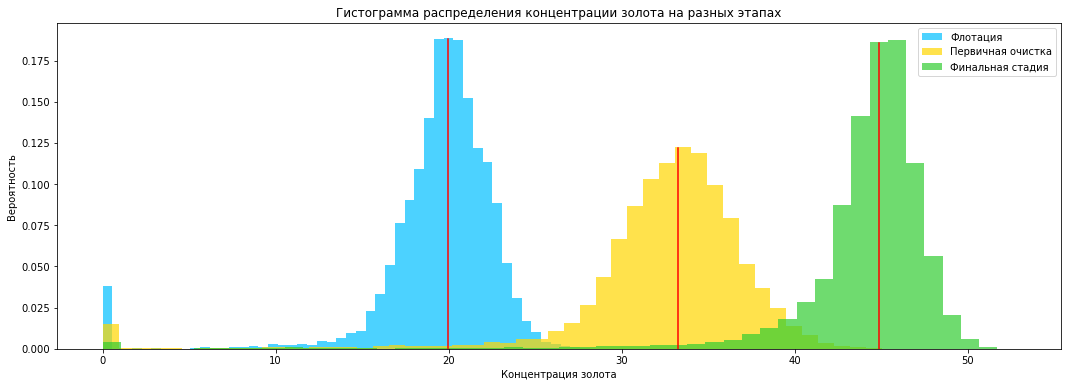

In [16]:
fig, ax = plt.subplots(figsize = (18, 6))

ax.hist(df_train["rougher.output.concentrate_au"], 50, alpha = 0.7, label = "Флотация", 
        density = True, color = "deepskyblue")

ax.axvline(x = df_train["rougher.output.concentrate_au"].median(), ymin = 0, 
           ymax = 0.951, color = "red")

ax.hist(df_train["primary_cleaner.output.concentrate_au"], 50, alpha = 0.7, 
        label = "Первичная очистка", density = True, color = "gold")

ax.axvline(x = df_train["primary_cleaner.output.concentrate_au"].median(), ymin = 0, 
           ymax = 0.615, color = "red")

ax.hist(df_train["final.output.concentrate_au"], 50, alpha = 0.7, label = "Финальная стадия", 
        density = True, color = "limegreen")

ax.axvline(x = df_train["final.output.concentrate_au"].median(), ymin = 0, 
           ymax = 0.938, color = "red")

plt.title("Гистограмма распределения концентрации золота на разных этапах")
plt.xlabel("Концентрация золота")
plt.ylabel("Вероятность")
plt.legend(loc = 0)
plt.show()

In [17]:
df_train[["rougher.output.concentrate_au", 
          "primary_cleaner.output.concentrate_au", "final.output.concentrate_au"]].describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
rougher.output.concentrate_au,14149.0,19.44,3.77,0.0,18.43,19.95,21.39,28.15
primary_cleaner.output.concentrate_au,14149.0,32.39,5.80,0.0,30.86,33.23,35.33,45.93
final.output.concentrate_au,14149.0,44.00,4.91,0.0,43.28,44.87,46.17,52.76


С каждым новым этапом технологического процесса концентрация золота становится выше, т. е. на одну тонну золотосодержащей руды приходится больше грамм чистого золота. Это логично, потому что на каждом этапе смесь золотосодержащей руды обогощается, и отбрасываются «отвальные хвосты». Об увеличении концентрации золота с каждым новым этапом говорит то, как изменяется медианное значение распределения концентрации золота на каждом этапе, а также увеличение максимального значения концентрации, т. е. остатки продукта с низкой концентрацией ценных металлов отбрасываются, и остается та часть продукта, где содержание ценных металлов выше. 

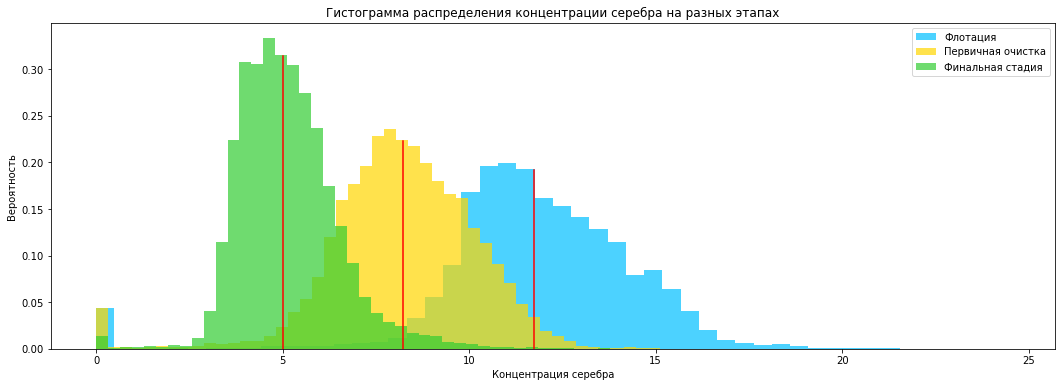

In [18]:
fig, ax = plt.subplots(figsize = (18, 6))

ax.hist(df_train["rougher.output.concentrate_ag"], 50, alpha = 0.7, label = "Флотация", 
        density = True, color = "deepskyblue")

ax.axvline(x = df_train["rougher.output.concentrate_ag"].median(), ymin = 0, 
           ymax = 0.548, color = "red")

ax.hist(df_train["primary_cleaner.output.concentrate_ag"], 50, alpha = 0.7, label = "Первичная очистка", 
        density = True, color = "gold")

ax.axvline(x = df_train["primary_cleaner.output.concentrate_ag"].median(), ymin = 0, 
           ymax = 0.638, color = "red")

ax.hist(df_train["final.output.concentrate_ag"], 50, alpha = 0.7, label = "Финальная стадия", 
        density = True, color = "limegreen")

ax.axvline(x = df_train["final.output.concentrate_ag"].median(), ymin = 0, 
           ymax = 0.899, color = "red")

plt.title("Гистограмма распределения концентрации серебра на разных этапах")
plt.xlabel("Концентрация серебра")
plt.ylabel("Вероятность")
plt.legend(loc = 0)
plt.show()

In [19]:
df_train[["rougher.output.concentrate_ag", 
          "primary_cleaner.output.concentrate_ag", "final.output.concentrate_ag"]].describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
rougher.output.concentrate_ag,14149.0,11.78,2.73,0.0,10.49,11.75,13.43,24.48
primary_cleaner.output.concentrate_ag,14149.0,8.20,2.01,0.0,7.11,8.23,9.50,16.08
final.output.concentrate_ag,14149.0,5.14,1.37,0.0,4.21,4.99,5.86,16.00


Что касается серебра, здесь наблюдается противоположная золоту ситуация. С каждым новым этапом концентрация серебра падает. Это видно по тому, как уменьшается медианное значение концентрации серебра на каждом этапе, как уменьшается стандартное отклонение распределения концентрации серебра. Причиной может быть то, что часть серебра отбрасывается вместе с остатками продукта, где низкое содержание ценных металлов.

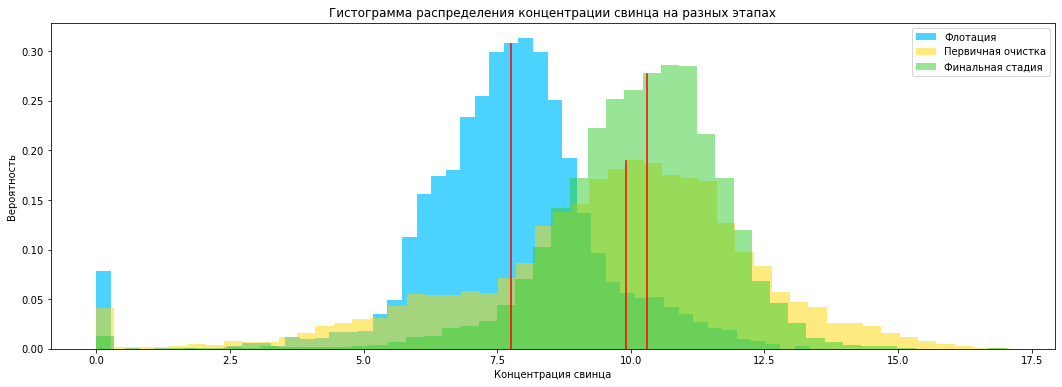

In [20]:
fig, ax = plt.subplots(figsize = (18, 6))

ax.hist(df_train["rougher.output.concentrate_pb"], 50, alpha = 0.7, label = "Флотация", 
        density = True, color = "deepskyblue")

ax.axvline(x = df_train["rougher.output.concentrate_pb"].median(), ymin = 0, 
           ymax = 0.936, color = "red")

ax.hist(df_train["primary_cleaner.output.concentrate_pb"], 50, alpha = 0.5, label = "Первичная очистка", 
        density = True, color = "gold")

ax.axvline(x = df_train["primary_cleaner.output.concentrate_pb"].median(), ymin = 0, 
           ymax = 0.575, color = "red")

ax.hist(df_train["final.output.concentrate_pb"], 50, alpha = 0.5, label = "Финальная стадия", 
        density = True, color = "limegreen")

ax.axvline(x = df_train["final.output.concentrate_pb"].median(), ymin = 0, 
           ymax = 0.843, color = "red")

plt.title("Гистограмма распределения концентрации свинца на разных этапах")
plt.xlabel("Концентрация свинца")
plt.ylabel("Вероятность")
plt.legend(loc = 0)
plt.show()

In [21]:
df_train[["rougher.output.concentrate_pb", 
          "primary_cleaner.output.concentrate_pb", "final.output.concentrate_pb"]].describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
rougher.output.concentrate_pb,14149.0,7.66,1.86,0.0,6.85,7.76,8.60,13.62
primary_cleaner.output.concentrate_pb,14149.0,9.57,2.70,0.0,8.31,9.92,11.30,17.08
final.output.concentrate_pb,14149.0,10.13,1.65,0.0,9.30,10.30,11.17,17.03


Изменение концентрации свинца напоминает изменение концентрации золота - с каждым новым этапом технологического процесса его концентрация растет, хоть и меньшими темпами. Мы можем это увидеть благодаря тому, что медианное значение концентрации свинца изменяется незначительно с этапа первночальной чистки до финального концентрата.

##### 2.2. Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках

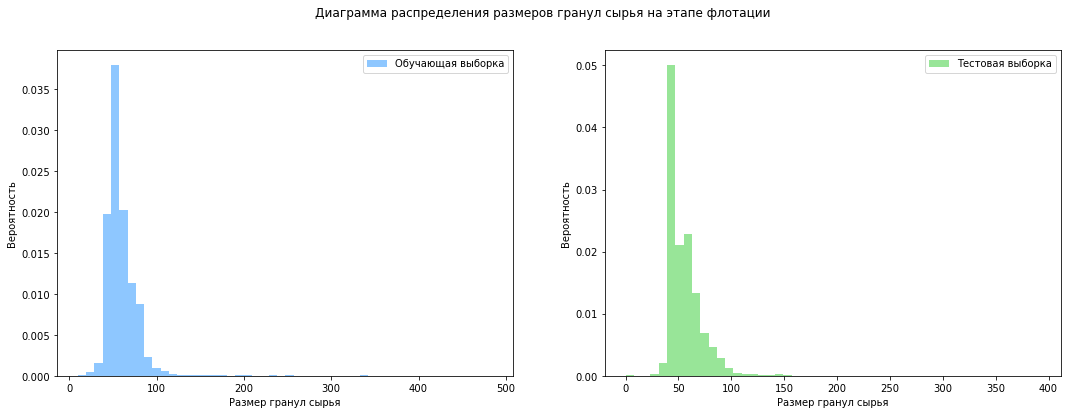

In [22]:
fig = plt.figure(figsize = (18, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.hist(df_train["rougher.input.feed_size"], 50, alpha = 0.5, label = "Обучающая выборка", 
         density = True, color = "dodgerblue")

ax1.set(xlabel = "Размер гранул сырья", ylabel = "Вероятность")

ax1.legend(loc = 0)

ax2.hist(df_test["rougher.input.feed_size"], 50, alpha = 0.5, label = "Тестовая выборка", 
         density = True, color = "limegreen")

ax2.set(xlabel = "Размер гранул сырья", ylabel = "Вероятность")

ax2.legend(loc = 0)
fig.suptitle("Диаграмма распределения размеров гранул сырья на этапе флотации")
plt.show()

In [23]:
temp1 = pd.concat([df_train["rougher.input.feed_size"], df_test["rougher.input.feed_size"]], 
          axis = 1)
temp1.columns = ["Обучающая выборка", "Тестовая выборка"]
temp1.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Обучающая выборка,14149.0,60.10,23.02,9.66,48.95,55.27,65.98,484.97
Тестовая выборка,5290.0,55.95,19.08,0.05,43.91,50.85,62.45,392.49


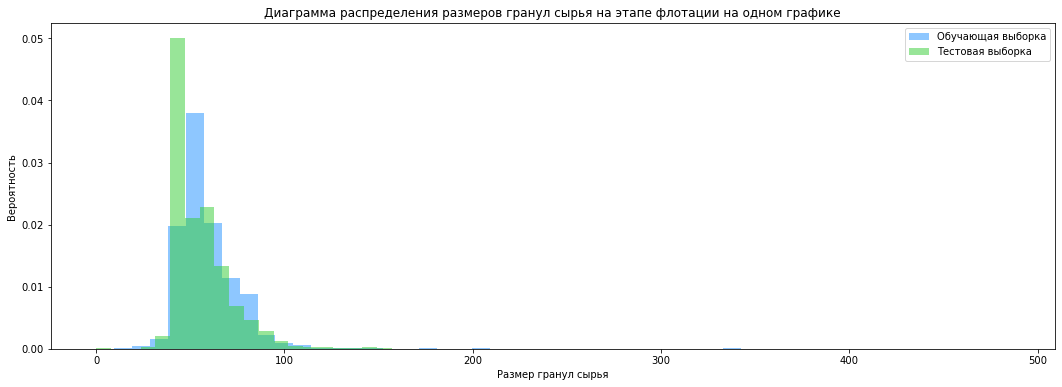

In [24]:
fig, ax = plt.subplots(figsize = (18, 6))
ax.hist(df_train["rougher.input.feed_size"], 50, alpha = 0.5, label = "Обучающая выборка", 
         density = True, color = "dodgerblue")
ax.hist(df_test["rougher.input.feed_size"], 50, alpha = 0.5, label = "Тестовая выборка", 
         density = True, color = "limegreen")
plt.title("Диаграмма распределения размеров гранул сырья на этапе флотации на одном графике")
plt.xlabel("Размер гранул сырья")
plt.ylabel("Вероятность")
plt.legend(loc = 0)
plt.show()

Если сравнить распределение размеров гранул сырья на этапе флотации на обучающей и тестовой выборках, то мы видим, что распределение немного смещается в сторону нуля. Это видно по тому, что минимальное значение на тестовой выборке равняется 0.05, а медиана - 50.85, в то время, как на обучающей выборки эти параметры равны 9.66 и 55.27, соответственно. Выбросы присутствуют на обеих выборках. Однако в плане разброса распределения размеров гранул сырья на тестовой выборке стандартное отклонение распределения ниже, чем на обучающей выборке.

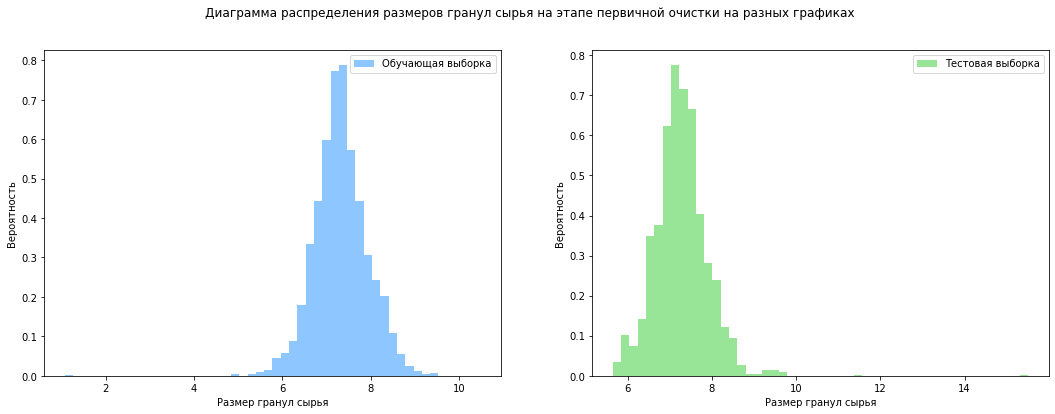

In [25]:
fig = plt.figure(figsize = (18, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.hist(df_train["primary_cleaner.input.feed_size"], 50, alpha = 0.5, label = "Обучающая выборка", 
         density = True, color = "dodgerblue")

ax1.set(xlabel = "Размер гранул сырья", ylabel = "Вероятность")

ax1.legend(loc = 0)

ax2.hist(df_test["primary_cleaner.input.feed_size"], 50, alpha = 0.5, label = "Тестовая выборка", 
         density = True, color = "limegreen")

ax2.set(xlabel = "Размер гранул сырья", ylabel = "Вероятность")

ax2.legend(loc = 0)
fig.suptitle("Диаграмма распределения размеров гранул сырья на этапе первичной очистки на разных графиках")
plt.show()

In [26]:
temp2 = pd.concat([df_train["primary_cleaner.input.feed_size"], df_test["primary_cleaner.input.feed_size"]], 
          axis = 1)
temp2.columns = ["Обучающая выборка", "Тестовая выборка"]
temp2.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Обучающая выборка,14149.0,7.32,0.61,1.08,6.96,7.29,7.7,10.47
Тестовая выборка,5290.0,7.27,0.61,5.65,6.89,7.25,7.6,15.50


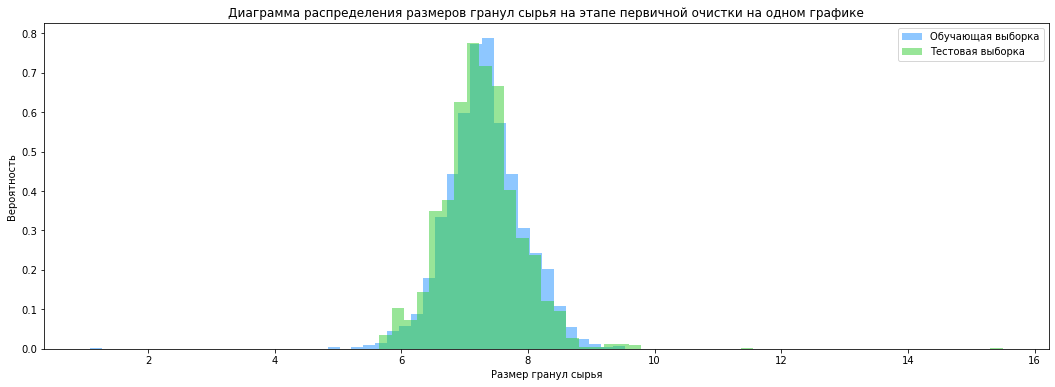

In [27]:
fig, ax = plt.subplots(figsize = (18, 6))
ax.hist(df_train["primary_cleaner.input.feed_size"], 50, alpha = 0.5, label = "Обучающая выборка", 
         density = True, color = "dodgerblue")
ax.hist(df_test["primary_cleaner.input.feed_size"], 50, alpha = 0.5, label = "Тестовая выборка", 
         density = True, color = "limegreen")
plt.title("Диаграмма распределения размеров гранул сырья на этапе первичной очистки на одном графике")
plt.xlabel("Размер гранул сырья")
plt.ylabel("Вероятность")
plt.legend(loc = 0)
plt.show()

Распределения размеров гранул сырья на этапе первичной очистки на обучающей и тестовой выборки существенно не отличаются. Стандартные отклонения и средние значения отличаются совсем незначительно.

##### 2.3. Исследование суммарной концентрации всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах

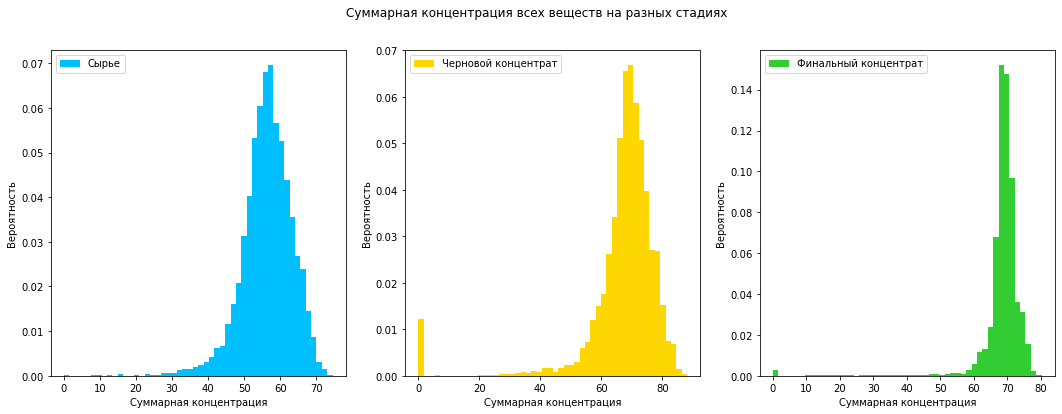

In [28]:
fig = plt.figure(figsize = (18, 6))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
fig.suptitle("Суммарная концентрация всех веществ на разных стадиях")


ax1.hist((
    df_train["rougher.input.feed_au"] + df_train["rougher.input.feed_ag"] +
    df_train["rougher.input.feed_pb"] + df_train["rougher.input.feed_sol"]
), 
    bins = 50, label = "Сырье", density = True, color = "deepskyblue"
)

ax1.set(xlabel = "Суммарная концентрация", ylabel = "Вероятность")

ax1.legend(loc = 0)


ax2.hist((
    df_train["rougher.output.concentrate_au"] + df_train["rougher.output.concentrate_ag"] +
    df_train["rougher.output.concentrate_pb"] + df_train["rougher.output.concentrate_sol"]
), 
    bins = 50, label = "Черновой концентрат", density = True, color = "gold"
)

ax2.set(xlabel = "Суммарная концентрация", ylabel = "Вероятность")

ax2.legend(loc = 0)



ax3.hist((
    df_train["final.output.concentrate_au"] + df_train["final.output.concentrate_ag"] +
    df_train["final.output.concentrate_pb"] + df_train["final.output.concentrate_sol"]
), 
    bins = 50, label = "Финальный концентрат", density = True, color = "limegreen"
)

ax3.set(xlabel = "Суммарная концентрация", ylabel = "Вероятность")

ax3.legend(loc = 0)


plt.show()

In [29]:
temp3 = pd.concat([
    (
        df_train["rougher.input.feed_au"] + df_train["rougher.input.feed_ag"] + \
        df_train["rougher.input.feed_pb"] + df_train["rougher.input.feed_sol"]
    ),
    (
        df_train["rougher.output.concentrate_au"] + df_train["rougher.output.concentrate_ag"] + \
        df_train["rougher.output.concentrate_pb"] + df_train["rougher.output.concentrate_sol"]
    ),
    (
        df_train["final.output.concentrate_au"] + df_train["final.output.concentrate_ag"] + \
        df_train["final.output.concentrate_pb"] + df_train["final.output.concentrate_sol"]
    )
], axis = 1)
temp3.columns = ["Сырье", "Черновой концентрат", "Финальный концентрат"]
temp3.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Сырье,14149.0,56.24,7.03,0.04,52.57,56.62,60.76,74.46
Черновой концентрат,14149.0,67.18,12.70,0.00,64.93,69.18,73.43,88.14
Финальный концентрат,14149.0,68.40,7.02,0.00,67.56,69.14,70.97,80.21


На графике распределения и в таблице мы видим, что суммарная концентрация всех веществ в черновом и финальном концентратах может равняться 0. Эти значения выглядят как выбросы. Так как нулевые значения суммарной концентрации маловероятны, то, скорее всего, это ошибки в данных.

### Шаг 3. Построение модели

##### 3.1. Написание функции для вычисления итоговой sMAPE

In [30]:
def calculate_smape(target, predictions):
    numerator = np.abs(target - predictions)
    denominator = (np.abs(target) + np.abs(predictions)) / 2 

    return 1 / len(target) * np.sum(numerator / denominator) * 100

In [31]:
smape_scorer = make_scorer(calculate_smape, greater_is_better = False)

##### 3.2. Обучение разных моделей и оценка их качества кросс-валидацией

##### Модель для прогнозирования эффективности обогащения чернового концентрата

In [32]:
# делим данные из обучающей выборки на фичи и таргет
features_train_rougher = df_train[['rougher.input.feed_ag', 
                        'rougher.input.feed_pb',
                        'rougher.input.feed_rate', 
                        'rougher.input.feed_size',
                        'rougher.input.feed_sol', 
                        'rougher.input.feed_au',
                        'rougher.input.floatbank10_sulfate',
                        'rougher.input.floatbank10_xanthate',
                        'rougher.input.floatbank11_sulfate',
                        'rougher.input.floatbank11_xanthate',
                        'rougher.state.floatbank10_a_air',
                        'rougher.state.floatbank10_a_level', 
                        'rougher.state.floatbank10_b_air',
                        'rougher.state.floatbank10_b_level', 
                        'rougher.state.floatbank10_c_air',
                        'rougher.state.floatbank10_c_level', 
                        'rougher.state.floatbank10_d_air',
                        'rougher.state.floatbank10_d_level', 
                        'rougher.state.floatbank10_e_air',
                        'rougher.state.floatbank10_e_level', 
                        'rougher.state.floatbank10_f_air',
                        'rougher.state.floatbank10_f_level']]

target_train_rougher = df_train['rougher.output.recovery']

In [33]:
# делим данные из тестовой выборки на фичи и таргет
features_test_rougher = df_test[['rougher.input.feed_ag', 
                        'rougher.input.feed_pb',
                        'rougher.input.feed_rate', 
                        'rougher.input.feed_size',
                        'rougher.input.feed_sol', 
                        'rougher.input.feed_au',
                        'rougher.input.floatbank10_sulfate',
                        'rougher.input.floatbank10_xanthate',
                        'rougher.input.floatbank11_sulfate',
                        'rougher.input.floatbank11_xanthate',
                        'rougher.state.floatbank10_a_air',
                        'rougher.state.floatbank10_a_level', 
                        'rougher.state.floatbank10_b_air',
                        'rougher.state.floatbank10_b_level', 
                        'rougher.state.floatbank10_c_air',
                        'rougher.state.floatbank10_c_level', 
                        'rougher.state.floatbank10_d_air',
                        'rougher.state.floatbank10_d_level', 
                        'rougher.state.floatbank10_e_air',
                        'rougher.state.floatbank10_e_level', 
                        'rougher.state.floatbank10_f_air',
                        'rougher.state.floatbank10_f_level']]

target_test_rougher = df.set_index("date").loc[df_test.set_index("date").index, 
                                          "rougher.output.recovery"].reset_index(drop = True)

target_test_rougher.columns = ["rougher.output.recovery"]

Стандартизируем набор признаков, чтобы устранить разные масштабы между ними.

In [34]:
rougher_scaler = StandardScaler()
rougher_scaler.fit(features_train_rougher)
features_train_rougher = rougher_scaler.transform(features_train_rougher)
features_test_rougher = rougher_scaler.transform(features_test_rougher)

В наборе данных есть фичи, между которыми высокая корреляция. Особенно это касается уровня жидкости на разных флотационных установках. Объяснить наличие высокой корреляции между этими признаками можно тем, что флотационные установки должны быть одинаковых размеров, и объем воды, которым их заполняют, должен быть примерно одинаковым. Поэтому отметим наличие мультиколлинеарности в данных. В связи с этим мы ожидаем, что линейную модель нужно будет регуляризовывать для получения качественной модели.

Для нахождения оптимальных значений гиперпараметров воспользуем `GridSearchCV`, в котором также заложена кросс-валидация. 

##### Ridge-регрессия

In [35]:
rougher_grid_ridge_regression = GridSearchCV(
    Ridge(random_state = 12345),
    param_grid = {"alpha" : [0.1, 1, 10, 100], "solver" : ["auto", "svd", "cholesky", "lsqr", "sparse_cg"]},
    cv = 5, scoring = smape_scorer)

In [36]:
rougher_grid_ridge_regression.fit(features_test_rougher, target_test_rougher)

GridSearchCV(cv=5, estimator=Ridge(random_state=12345),
             param_grid={'alpha': [0.1, 1, 10, 100],
                         'solver': ['auto', 'svd', 'cholesky', 'lsqr',
                                    'sparse_cg']},
             scoring=make_scorer(calculate_smape, greater_is_better=False))

In [37]:
rougher_grid_ridge_regression.best_params_

{'alpha': 100, 'solver': 'lsqr'}

In [38]:
print("sMAPE для гребневой регрессии:", abs(rougher_grid_ridge_regression.best_score_).round(2))

sMAPE для гребневой регрессии: 10.02


In [39]:
print("Среднее время обучения гребневой регрессии:",
      rougher_grid_ridge_regression.cv_results_["mean_fit_time"][13].round(4), "сек.")

Среднее время обучения гребневой регрессии: 0.0027 сек.


In [40]:
print("Среднее время предсказания на гребневой регрессии:",
      rougher_grid_ridge_regression.cv_results_["mean_score_time"][13].round(4), "сек.")

Среднее время предсказания на гребневой регрессии: 0.0006 сек.


##### LASSO-регрессия

In [41]:
rougher_grid_lasso_regression = GridSearchCV(
    Lasso(random_state = 12345), param_grid = {"alpha" : [0.1, 1, 10, 100]},
    cv = 5, scoring = smape_scorer
)

In [42]:
rougher_grid_lasso_regression.fit(features_test_rougher, target_test_rougher)

GridSearchCV(cv=5, estimator=Lasso(random_state=12345),
             param_grid={'alpha': [0.1, 1, 10, 100]},
             scoring=make_scorer(calculate_smape, greater_is_better=False))

In [43]:
rougher_grid_lasso_regression.best_params_

{'alpha': 1}

In [44]:
print("sMAPE для LASSO-регрессии:", abs(rougher_grid_lasso_regression.best_score_).round(2))

sMAPE для LASSO-регрессии: 8.95


In [45]:
print("Среднее время обучения LASSO-регрессии:",
      rougher_grid_lasso_regression.cv_results_["mean_fit_time"][3].round(4), "сек.")

Среднее время обучения LASSO-регрессии: 0.0015 сек.


In [46]:
print("Среднее время предсказания на LASSO-регрессии:",
      rougher_grid_lasso_regression.cv_results_["mean_score_time"][3].round(4), "сек.")

Среднее время предсказания на LASSO-регрессии: 0.0006 сек.


##### Выбор лучшей модели и проверка на тестовой выборке

Как мы видим, лучший результат показала LASSO-регрессия. Хоть и разница во времени обучении моделей незначительная, все же LASSO-регрессия обучается немного быстрее. А время прогнозирования на Ridge- и LASSO-регрессии практически одинаковое.

In [47]:
rougher_lasso_predictions = rougher_grid_lasso_regression.predict(features_test_rougher)

In [48]:
print("sMAPE для LASSO-регрессии на тестовой выборке:", 
      calculate_smape(target_test_rougher, rougher_lasso_predictions).round(2))

sMAPE для LASSO-регрессии на тестовой выборке: 8.03


На тестовой выборке результат модели улучшился по сравнению с обучающей выборкой.

##### Модель для прогнозирования эффективности обогащения финального концентрата

In [49]:
# выделяем ту часть таблицы с обучающей выборкой, которая нужна нам
# в объединенной таблице удаляем строки с пропусками, чтобы данные не сбились
features_train_final = df_train[['primary_cleaner.input.sulfate', 
                           'primary_cleaner.input.depressant',
                           'primary_cleaner.input.feed_size', 
                           'primary_cleaner.input.xanthate',
                           'primary_cleaner.state.floatbank8_a_air',
                           'primary_cleaner.state.floatbank8_a_level',
                           'primary_cleaner.state.floatbank8_b_air',
                           'primary_cleaner.state.floatbank8_b_level',
                           'primary_cleaner.state.floatbank8_c_air',
                           'primary_cleaner.state.floatbank8_c_level',
                           'primary_cleaner.state.floatbank8_d_air',
                           'primary_cleaner.state.floatbank8_d_level',
                           'rougher.input.feed_ag',
                           'rougher.input.feed_pb', 
                           'rougher.input.feed_rate',
                           'rougher.input.feed_size', 
                           'rougher.input.feed_sol',
                           'rougher.input.feed_au', 
                           'rougher.input.floatbank10_sulfate',
                           'rougher.input.floatbank10_xanthate',
                           'rougher.input.floatbank11_sulfate',
                           'rougher.input.floatbank11_xanthate', 
                           'rougher.state.floatbank10_a_air',
                           'rougher.state.floatbank10_a_level', 
                           'rougher.state.floatbank10_b_air',
                           'rougher.state.floatbank10_b_level', 
                           'rougher.state.floatbank10_c_air',
                           'rougher.state.floatbank10_c_level', 
                           'rougher.state.floatbank10_d_air',
                           'rougher.state.floatbank10_d_level', 
                           'rougher.state.floatbank10_e_air',
                           'rougher.state.floatbank10_e_level', 
                           'rougher.state.floatbank10_f_air',
                           'rougher.state.floatbank10_f_level',
                           'secondary_cleaner.state.floatbank2_a_air',
                           'secondary_cleaner.state.floatbank2_a_level',
                           'secondary_cleaner.state.floatbank2_b_air',
                           'secondary_cleaner.state.floatbank2_b_level',
                           'secondary_cleaner.state.floatbank3_a_air',
                           'secondary_cleaner.state.floatbank3_a_level',
                           'secondary_cleaner.state.floatbank3_b_air',
                           'secondary_cleaner.state.floatbank3_b_level',
                           'secondary_cleaner.state.floatbank4_a_air',
                           'secondary_cleaner.state.floatbank4_a_level',
                           'secondary_cleaner.state.floatbank4_b_air',
                           'secondary_cleaner.state.floatbank4_b_level',
                           'secondary_cleaner.state.floatbank5_a_air',
                           'secondary_cleaner.state.floatbank5_a_level',
                           'secondary_cleaner.state.floatbank5_b_air',
                           'secondary_cleaner.state.floatbank5_b_level',
                           'secondary_cleaner.state.floatbank6_a_air',
                           'secondary_cleaner.state.floatbank6_a_level']]

target_train_final = df_train["final.output.recovery"]

In [50]:
features_test_final = df_test[['primary_cleaner.input.sulfate', 
                           'primary_cleaner.input.depressant',
                           'primary_cleaner.input.feed_size', 
                           'primary_cleaner.input.xanthate',
                           'primary_cleaner.state.floatbank8_a_air',
                           'primary_cleaner.state.floatbank8_a_level',
                           'primary_cleaner.state.floatbank8_b_air',
                           'primary_cleaner.state.floatbank8_b_level',
                           'primary_cleaner.state.floatbank8_c_air',
                           'primary_cleaner.state.floatbank8_c_level',
                           'primary_cleaner.state.floatbank8_d_air',
                           'primary_cleaner.state.floatbank8_d_level',
                           'rougher.input.feed_ag',
                           'rougher.input.feed_pb', 
                           'rougher.input.feed_rate',
                           'rougher.input.feed_size', 
                           'rougher.input.feed_sol',
                           'rougher.input.feed_au', 
                           'rougher.input.floatbank10_sulfate',
                           'rougher.input.floatbank10_xanthate',
                           'rougher.input.floatbank11_sulfate',
                           'rougher.input.floatbank11_xanthate', 
                           'rougher.state.floatbank10_a_air',
                           'rougher.state.floatbank10_a_level', 
                           'rougher.state.floatbank10_b_air',
                           'rougher.state.floatbank10_b_level', 
                           'rougher.state.floatbank10_c_air',
                           'rougher.state.floatbank10_c_level', 
                           'rougher.state.floatbank10_d_air',
                           'rougher.state.floatbank10_d_level', 
                           'rougher.state.floatbank10_e_air',
                           'rougher.state.floatbank10_e_level', 
                           'rougher.state.floatbank10_f_air',
                           'rougher.state.floatbank10_f_level',
                           'secondary_cleaner.state.floatbank2_a_air',
                           'secondary_cleaner.state.floatbank2_a_level',
                           'secondary_cleaner.state.floatbank2_b_air',
                           'secondary_cleaner.state.floatbank2_b_level',
                           'secondary_cleaner.state.floatbank3_a_air',
                           'secondary_cleaner.state.floatbank3_a_level',
                           'secondary_cleaner.state.floatbank3_b_air',
                           'secondary_cleaner.state.floatbank3_b_level',
                           'secondary_cleaner.state.floatbank4_a_air',
                           'secondary_cleaner.state.floatbank4_a_level',
                           'secondary_cleaner.state.floatbank4_b_air',
                           'secondary_cleaner.state.floatbank4_b_level',
                           'secondary_cleaner.state.floatbank5_a_air',
                           'secondary_cleaner.state.floatbank5_a_level',
                           'secondary_cleaner.state.floatbank5_b_air',
                           'secondary_cleaner.state.floatbank5_b_level',
                           'secondary_cleaner.state.floatbank6_a_air',
                           'secondary_cleaner.state.floatbank6_a_level']]

target_test_final = df.set_index("date").loc[df_test.set_index("date").index, 
                                          "final.output.recovery"].reset_index(drop = True)

target_test_final.columns = ["final.output.recovery"]

In [51]:
final_scaler = StandardScaler()
final_scaler.fit(features_train_final)
features_train_final = final_scaler.transform(features_train_final)
features_test_final = final_scaler.transform(features_test_final)

##### Ridge-регрессия

In [52]:
final_grid_ridge_regression = GridSearchCV(
    Ridge(random_state = 12345),
    param_grid = {"alpha" : [0.1, 1, 10, 100], "solver" : ["auto", "svd", "cholesky", "lsqr", "sparse_cg"]},
    cv = 5, scoring = smape_scorer)

In [53]:
final_grid_ridge_regression.fit(features_train_final, target_train_final)

GridSearchCV(cv=5, estimator=Ridge(random_state=12345),
             param_grid={'alpha': [0.1, 1, 10, 100],
                         'solver': ['auto', 'svd', 'cholesky', 'lsqr',
                                    'sparse_cg']},
             scoring=make_scorer(calculate_smape, greater_is_better=False))

In [54]:
final_grid_ridge_regression.best_params_

{'alpha': 100, 'solver': 'lsqr'}

In [55]:
print("sMAPE для гребневой регрессии:", abs(final_grid_ridge_regression.best_score_).round(2))

sMAPE для гребневой регрессии: 11.68


In [56]:
print("Среднее время обучения гребневой регрессии:",
      final_grid_ridge_regression.cv_results_["mean_fit_time"][19].round(4), "сек.")

Среднее время обучения гребневой регрессии: 0.0097 сек.


In [57]:
print("Среднее время предсказания на гребневой регрессии:",
      final_grid_ridge_regression.cv_results_["mean_score_time"][19].round(4), "сек.")

Среднее время предсказания на гребневой регрессии: 0.0008 сек.


##### LASSO-регрессия

In [58]:
final_grid_lasso_regression = GridSearchCV(
    Lasso(max_iter = 10000, random_state = 12345), param_grid = {"alpha" : [0.1, 1, 10, 100]},
    cv = 5, scoring = smape_scorer
)

In [59]:
final_grid_lasso_regression.fit(features_train_final, target_train_final)

GridSearchCV(cv=5, estimator=Lasso(max_iter=10000, random_state=12345),
             param_grid={'alpha': [0.1, 1, 10, 100]},
             scoring=make_scorer(calculate_smape, greater_is_better=False))

In [60]:
final_grid_lasso_regression.best_params_

{'alpha': 1}

In [61]:
print("sMAPE для LASSO-регрессии:", abs(final_grid_lasso_regression.best_score_).round(2))

sMAPE для LASSO-регрессии: 10.17


In [62]:
print("Среднее время обучения LASSO-регрессии:",
      final_grid_lasso_regression.cv_results_["mean_fit_time"][3].round(4), "сек.")

Среднее время обучения LASSO-регрессии: 0.0059 сек.


In [63]:
print("Среднее время предсказания на LASSO-регрессии:",
      final_grid_lasso_regression.cv_results_["mean_score_time"][3].round(4), "сек.")

Среднее время предсказания на LASSO-регрессии: 0.0008 сек.


##### Выбор лучшей модели и проверка на тестовой выборке

Для прогнозирования эффективности обогащения финального концентрата также лучшей моделью стала LASSO-регрессия. Ее sMAPE равняется 10.17. В плане времени обучения LASSO-регрессия обучается быстрее, но по времени предсказания гребневая и LASSO-регрессии показали одинакой результат.

In [64]:
final_lasso_predictions = final_grid_lasso_regression.predict(features_test_final)

In [65]:
print("sMAPE для LASSO-регрессии на тестовой выборке:", 
      calculate_smape(target_test_final, final_lasso_predictions).round(2))

sMAPE для LASSO-регрессии на тестовой выборке: 8.7


##### Итоговый sMAPE

In [66]:
final_smape = 0.25 * calculate_smape(target_test_rougher, 
            rougher_lasso_predictions) + 0.75 * calculate_smape(target_test_final, final_lasso_predictions)

print("Итоговый sMAPE:", final_smape.round(2))

Итоговый sMAPE: 8.53


##### Проверка на адекватность

##### Обогащение чернового концентрата

In [67]:
rougher_dummy_regr = GridSearchCV(
    DummyRegressor(), param_grid = {"strategy" : ["mean", "median"]},
    cv = 5, scoring = smape_scorer
)

In [68]:
rougher_dummy_regr.fit(features_train_rougher, target_train_rougher)

GridSearchCV(cv=5, estimator=DummyRegressor(),
             param_grid={'strategy': ['mean', 'median']},
             scoring=make_scorer(calculate_smape, greater_is_better=False))

In [69]:
rougher_dummy_regr.best_params_

{'strategy': 'median'}

In [70]:
print("sMAPE для константной модели на обучающей выборке:", abs(rougher_dummy_regr.best_score_).round(2))

sMAPE для константной модели на обучающей выборке: 11.89


In [71]:
rougher_dummy_predictions = rougher_dummy_regr.predict(features_test_rougher)

In [72]:
print("sMAPE для константной модели на тестовой выборке:", 
      calculate_smape(target_test_final, rougher_dummy_predictions).round(2))

sMAPE для константной модели на тестовой выборке: 23.24


##### Обогащение финального концентрата

In [73]:
final_dummy_regr = GridSearchCV(
    DummyRegressor(), param_grid = {"strategy" : ["mean", "median"]},
    cv = 5, scoring = smape_scorer
)

In [74]:
final_dummy_regr.fit(features_test_final, target_test_final)

GridSearchCV(cv=5, estimator=DummyRegressor(),
             param_grid={'strategy': ['mean', 'median']},
             scoring=make_scorer(calculate_smape, greater_is_better=False))

In [75]:
final_dummy_regr.best_params_

{'strategy': 'median'}

In [76]:
print("sMAPE для константной модели на обучающей выборке:", abs(final_dummy_regr.best_score_).round(2))

sMAPE для константной модели на обучающей выборке: 9.46


In [77]:
final_dummy_predictions = final_dummy_regr.predict(features_test_final)

In [78]:
print("sMAPE для константной модели на тестовой выборке:", 
      calculate_smape(target_test_final, final_dummy_predictions).round(2))

sMAPE для константной модели на тестовой выборке: 9.17


##### Итоговый sMAPE

In [79]:
const_model_final_smape = 0.25 * calculate_smape(target_test_rougher, 
            rougher_dummy_predictions) + 0.75 * calculate_smape(target_test_final, final_dummy_predictions)

print("Итоговый sMAPE константной модели:", const_model_final_smape.round(2))

Итоговый sMAPE константной модели: 9.03


### Шаг 4. Общие выводы
---
В ходе данной работы:

1. мы подготовили данные;
2. провели исследовательский анализ данных;
3. построили и оценили разные модели;
4. выборали лучшую модель и оценили ее на тестовой выборке;
5. сравнили адекватность лучшей модели по сравнению с константной моделью.

В результате лучшей моделью для прогнозирования эффективности обогащения как чернового концентрата, так финального концентрата оказалась LASSO-регрессия с гиперпараметром $\lambda$, равным 1.

На обучающей выборке для прогнозирования эффективности обогащения чернового концентрата значение sMAPE составило 8.95, на тестовой выборке оно улучшилось до 8.03.

На данных для прогнозирования эффективности обогащения финального концентрата улучшение оказалось более значимым, потому что на обучающей выборке мы получили sMAPE, равный 10.17, а на тестовой - 8.7.

Итоговый sMAPE для чернового и финального концентратов составил 8.53.

Чтобы получить какой-то ориентир для оценки полученного итогового sMAPE, мы посчитали его также для константной модели, которая в качестве прогноза дает медианное значение выборки. В результате мы получили, что итоговый sMAPE константной модели равняется 9.03.

Таким образом, построенная нами модель прошла проверку на адекватность.